<h2><font color="#009999"><center>APPROXIMATION DE L'AIRE SOUS LA COURBE DEBIT VOLUME A L'AIDE DES ALGORYTHMES DE MACHINE LEARNING</center></font></h2>

### Importation des librairies pour l'analyse

In [69]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap as sh

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
#from scipy.stats import norm, uniform
from scipy.stats import shapiro
#from numpy.random import randn

> **<h3><font color="#0000FF">I - IMPORTATION DE LA BASE ET PRETRAITEMENT DES DONNEES</font></h3>**

In [70]:
# Fonction d'importation et prétraitement de la base
def pretraitement (url):
    df = pd.read_csv(url)
    #Renommer les variables d'intérèts
    df.columns = df.columns.str.replace('cvf1', 'cvf')
    df.columns = df.columns.str.replace('vem1', 'vems')
    df.columns = df.columns.str.replace('dem25ls2', 'dem25')
    df.columns = df.columns.str.replace('dem50ls2', 'dem50')
    df.columns = df.columns.str.replace('dem75ls2', 'dem75')
    #df.columns = df.columns.str.replace('vemscvf1', 'vemscvf')
    df.columns = df.columns.str.replace('vemscvf', 'vems/cvf')
    df.columns = df.columns.str.replace('bmi', 'imc')
    df.columns = df.columns.str.replace('aex1', 'aex4')
    # sélection des variables d'intérèts
    variables = ['sexe', 'age', 'imc', 'vems','cvf','vems/cvf', 'dem25', 'dem50', 'dem75','aex4']
    df = df[variables]
    #Supression des valeurs manquantes
    df = df.dropna(axis = 0)
    #Correction des types des données
    # Variables catégorielles
    df["sexe"]=pd.Categorical(df["sexe"],ordered=False)
    # Variables numériques
    df['age'] = df['age'].astype(float, errors = 'raise')
    df['vems/cvf'] = df['vems/cvf'].astype(float, errors = 'raise')
    # Renommage de la variable qualitative
    df["sexe"]=df["sexe"].cat.rename_categories(["homme","femme"])
    # Calcul de aex de la population d'étude
    for label, row in df.iterrows():
        df.loc[label,'aex_cameroun'] = row['vems/cvf']*row['vems'] + row['vems'] + row['dem25']*0.25*row['cvf'] - row['vems/cvf']*row['vems'] + row['dem25'] + row['dem50']*0.25*row['cvf'] + row['dem50'] + row['dem75']*0.25*row['cvf'] + row['dem75']*0.25*row['cvf']*0.5
        df['aex_cameroun'] = df['aex_cameroun'].round(2)
        df['imc'] = df['imc'].round(2)
        df.reset_index()
    return df

url = 'https://raw.githubusercontent.com/pefura/lung-function/main/Aex_dataset.csv'
df = pretraitement(url)
print('Dimenssions de la table des données')
print(df.shape)
print('')
print('')
print('Liste des variables du de la table')
print('')
print(df.columns)
print('Les deux premières lignes de la base')
df.head(2)

Dimenssions de la table des données
(220, 11)


Liste des variables du de la table

Index(['sexe', 'age', 'imc', 'vems', 'cvf', 'vems/cvf', 'dem25', 'dem50',
       'dem75', 'aex4', 'aex_cameroun'],
      dtype='object')
Les deux premières lignes de la base


,sexe,age,imc,vems,cvf,vems/cvf,dem25,dem50,dem75,aex4,aex_cameroun
0,homme,80.0,27.25,2.19,2.57,85.0,1.30,4.36,6.61,7.39,17.86
1,femme,88.0,35.60,1.01,1.28,79.0,0.52,1.58,2.08,1.49,4.78


In [71]:
#vérification des types des données de la base
for col in df.columns:
    print(col, df[col].dtype, sep=" --- ")

sexe --- category
age --- float64
imc --- float64
vems --- float64
cvf --- float64
vems/cvf --- float64
dem25 --- float64
dem50 --- float64
dem75 --- float64
aex4 --- float64
aex_cameroun --- float64


> **<h3><font color="#0000FF">II - ANALYSEs STATISTIQUES</font></h3>**

> **1 - Statistiques descriptives univariées**

> 1 - 1. Variable qualitative

In [72]:
# variable qualitative (sexe)
print('Répartition des genres dans la PE')
print(df["sexe"].value_counts())
print('')
print('Pourcentage du genre')
print(df["sexe"].value_counts(normalize = True)*100)

Répartition des genres dans la PE
femme    127
homme     93
Name: sexe, dtype: int64

Pourcentage du genre
femme    57.727273
homme    42.272727
Name: sexe, dtype: float64


<Axes: xlabel='sexe', ylabel='count'>

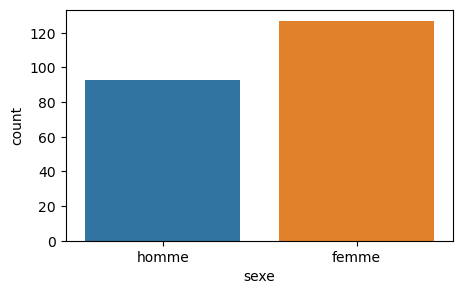

In [73]:
# visualisation de la répartition 
plt.figure(figsize = (5,3))
sns.countplot(x = df.sexe)

> 1 - 2. Variables quantitatives

#### Description numérique

In [74]:
num = df.drop(columns = ['sexe']).agg(["count", "min", "max", "median", "mean", "std", "skew"]).T
num

,count,min,max,median,mean,std,skew
age,220.0,7.00,88.00,48.000,46.331818,22.100722,-0.112791
imc,220.0,13.02,57.81,27.140,27.662909,7.129632,1.037962
vems,220.0,0.54,4.36,2.035,2.049227,0.799872,0.236369
cvf,220.0,0.67,5.15,2.495,2.509182,0.927272,0.282427
vems/cvf,220.0,38.00,100.00,84.000,81.440909,9.811053,-1.512982
dem25,220.0,0.09,4.62,1.080,1.173045,0.693689,1.212901
dem50,220.0,0.26,9.27,3.125,3.237273,1.631820,0.683230
dem75,220.0,0.51,12.42,5.230,5.207227,2.255535,0.333469
aex4,220.0,0.39,29.42,6.190,7.223864,5.295458,1.031177
aex_cameroun,220.0,1.41,51.31,13.735,15.078591,8.942074,0.814164


#### visualisation des distributions des variables numériques

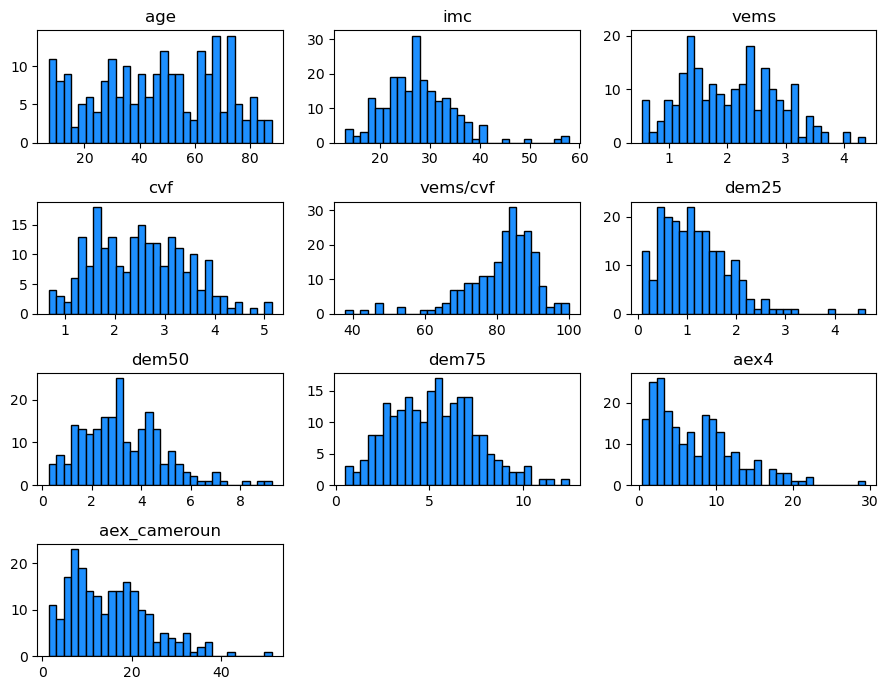

In [75]:
def hist_var(df, bins ):
    fig = plt.figure (figsize= (9,7))
    ax = fig.gca()
    hist = df.iloc[:-1].hist(ax = ax, bins=bins, grid= False, edgecolor = "black", color = "#1E90FF")
    fig.tight_layout()

hist_var(df, bins=30)

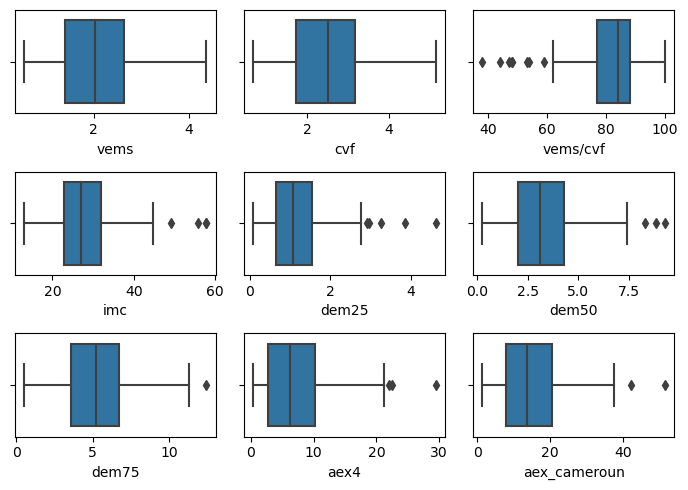

In [76]:
fig = plt.figure (figsize= (7,5))

plt.subplot(3,3,1)
sns.boxplot(x=df["vems"])

plt.subplot(3,3,2)
sns.boxplot(x=df["cvf"])

plt.subplot(3,3,3)
sns.boxplot(x=df["vems/cvf"])

plt.subplot(3,3,4)
sns.boxplot(x=df["imc"])

plt.subplot(3,3,5)
sns.boxplot(x=df["dem25"])

plt.subplot(3,3,6)
sns.boxplot(x=df["dem50"])

plt.subplot(3,3,7)
sns.boxplot(x=df["dem75"])

plt.subplot(3,3,8)
sns.boxplot(x=df["aex4"])

plt.subplot(3,3,9)
sns.boxplot(x=df["aex_cameroun"])
fig.tight_layout()

> 1 - 3. **Statistiques des variables numériques regroupées selon les modalité de la variable sexe**

In [77]:
moyenne_groupe = df.groupby('sexe').mean()
mediane_groupe = df.groupby('sexe').median()
ecart_type_groupe = df.groupby('sexe').std()
caracteristique_groupe = pd.concat([moyenne_groupe, mediane_groupe, ecart_type_groupe], ignore_index = True).rename(index={0: 'moyenne_homme', 1: 'moyenne_femme', 2: 'mediane_homme', 3: 'mediane_femme', 4: 'ecart_type_homme', 5: 'ecart_type_femme'}).T
caracteristique_groupe

,moyenne_homme,moyenne_femme,mediane_homme,mediane_femme,ecart_type_homme,ecart_type_femme
age,42.075269,49.448819,42.00,49.00,23.189314,20.812355
imc,25.390538,29.326929,25.26,28.40,6.027769,7.430911
vems,2.280538,1.879843,2.35,1.82,0.835005,0.731111
cvf,2.846022,2.262520,2.79,2.30,0.944055,0.835857
vems/cvf,79.784946,82.653543,83.00,84.00,11.227731,8.470657
dem25,1.303548,1.077480,1.23,0.98,0.740032,0.643999
dem50,3.563763,2.998189,3.48,2.82,1.740653,1.509862
dem75,5.691505,4.852598,5.80,4.92,2.420061,2.065496
aex4,8.778387,6.085512,8.36,5.20,6.071339,4.328416
aex_cameroun,17.641075,13.202126,17.79,11.39,9.751128,7.820286


#### Ecart entre les valeurs extrèmes de aex_cameroun par rapport au genre

In [78]:
diff_aex_cameroun = df.groupby('sexe')['aex_cameroun']\
                        .apply(lambda x : x.max()-x.min())
diff_aex_cameroun.sort_values(ascending = False).head()

sexe
homme    49.82
femme    35.18
Name: aex_cameroun, dtype: float64

#### Ecart entre les valeurs extrèmes de aex4 par rapport au genre

In [79]:
diff_aex_cameroun = df.groupby('sexe')['aex4']\
                        .apply(lambda x : x.max()-x.min())
diff_aex_cameroun.sort_values(ascending = False).head()

sexe
homme    28.90
femme    17.79
Name: aex4, dtype: float64

> 1 - 4. Tableau de correlation entre aex_cameroun et les autres variables 

In [80]:
df.corr()["aex_cameroun"]

age            -0.335873
imc             0.035093
vems            0.947805
cvf             0.874234
vems/cvf        0.400565
dem25           0.811189
dem50           0.903500
dem75           0.933297
aex4            0.969164
aex_cameroun    1.000000
Name: aex_cameroun, dtype: float64

> 1 - 5. Visualisation de la matrice de corrélation 

<Axes: >

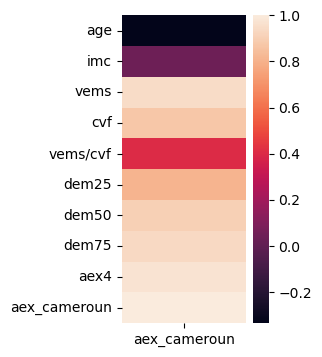

In [81]:
fig = plt.figure (figsize= (2,4))
sns.heatmap(pd.DataFrame([df.corr()["aex_cameroun"]]).T)

In [82]:
#plt.plot(x_coordinates,y_coordinates)

> test de normalité

In [83]:
# test de shapiro
print('age');
print(shapiro(df ['age']));
print('vem');
print(shapiro(df ['vems']));
print('cvf');
print(shapiro(df ['cvf']));
print('vems/cvf');
print(shapiro(df ['vems/cvf']));
print('imc');
print(shapiro(df ['imc']));
print('dem25');
print(shapiro(df ['dem25']));
print('dem50');
print(shapiro(df ['dem50']));
print('dem75');
print(shapiro(df ['dem75']));
print('aex4');
print(shapiro(df ['aex4']));
print('aex_cameroun');
print(shapiro(df ['aex_cameroun']))

age
ShapiroResult(statistic=0.9630807042121887, pvalue=1.7610434952075593e-05)
vem
ShapiroResult(statistic=0.9808815121650696, pvalue=0.00445652287453413)
cvf
ShapiroResult(statistic=0.9837042689323425, pvalue=0.012350726872682571)
vems/cvf
ShapiroResult(statistic=0.8909276723861694, pvalue=1.555525673546665e-11)
imc
ShapiroResult(statistic=0.944932758808136, pvalue=2.083883572367995e-07)
dem25
ShapiroResult(statistic=0.9314005374908447, pvalue=1.2801110393922954e-08)
dem50
ShapiroResult(statistic=0.9696213006973267, pvalue=0.00011391218868084252)
dem75
ShapiroResult(statistic=0.9877090454101562, pvalue=0.05546912923455238)
aex4
ShapiroResult(statistic=0.9179260730743408, pvalue=1.0904118719068379e-09)
aex_cameroun
ShapiroResult(statistic=0.9502086043357849, pvalue=6.885423999847262e-07)


> 2 - Descriptions bivariées

> 2 - 1. Analyses bivariées entre le sexe et les variables aex4 et aex_cameroun

        aex4                                                     
       count      mean       std   min   25%   50%     75%    max
sexe                                                             
homme   93.0  8.778387  6.071339  0.52  3.47  8.36  12.690  29.42
femme  127.0  6.085512  4.328416  0.39  2.57  5.20   9.065  18.18


<Axes: xlabel='aex4', ylabel='sexe'>

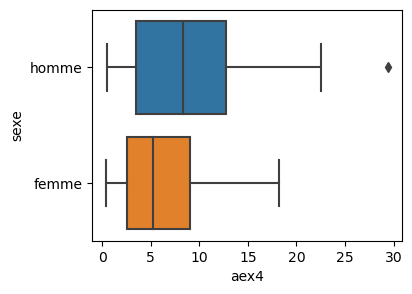

In [84]:
#  sexe et aex4
print(df[["aex4", "sexe"]].groupby("sexe").describe())
fig = plt.figure (figsize= (4,3))
sns.boxplot( data=df, x ="aex4", y = "sexe")

      aex_cameroun                                                       
             count       mean       std   min    25%    50%    75%    max
sexe                                                                     
homme         93.0  17.641075  9.751128  1.49  10.25  17.79  23.90  51.31
femme        127.0  13.202126  7.820286  1.41   6.90  11.39  18.53  36.59


<Axes: xlabel='aex_cameroun', ylabel='sexe'>

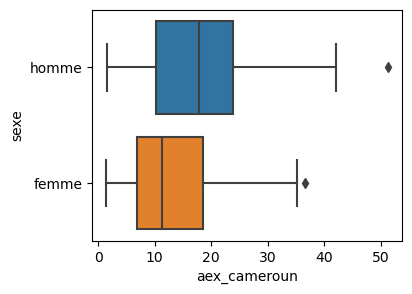

In [85]:
#  sexe et aex_cameroun
print(df[["aex_cameroun", "sexe"]].groupby("sexe").describe())
fig = plt.figure (figsize= (4,3))
sns.boxplot(data=df, x ="aex_cameroun", y = "sexe")

<Figure size 400x300 with 0 Axes>

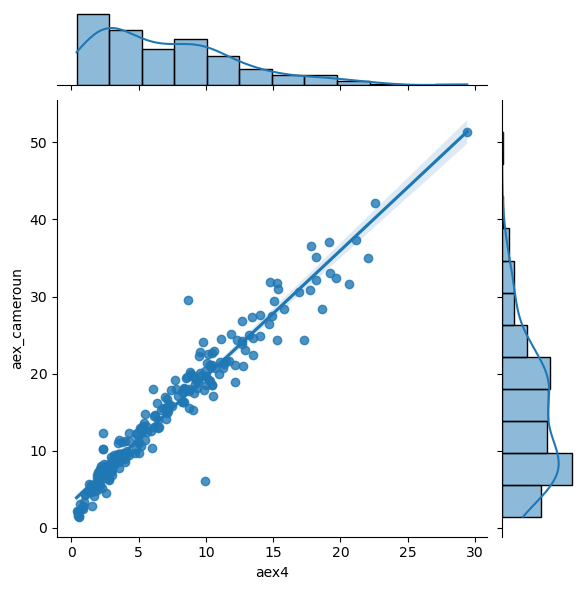

In [86]:
fig = plt.figure (figsize= (4,3))
sns.jointplot(x = "aex4", y = "aex_cameroun", kind = 'reg', data = df)

> Descriptions graphique de la relation entre aex_cameroun (variable expliquée) et les autres variables numériques

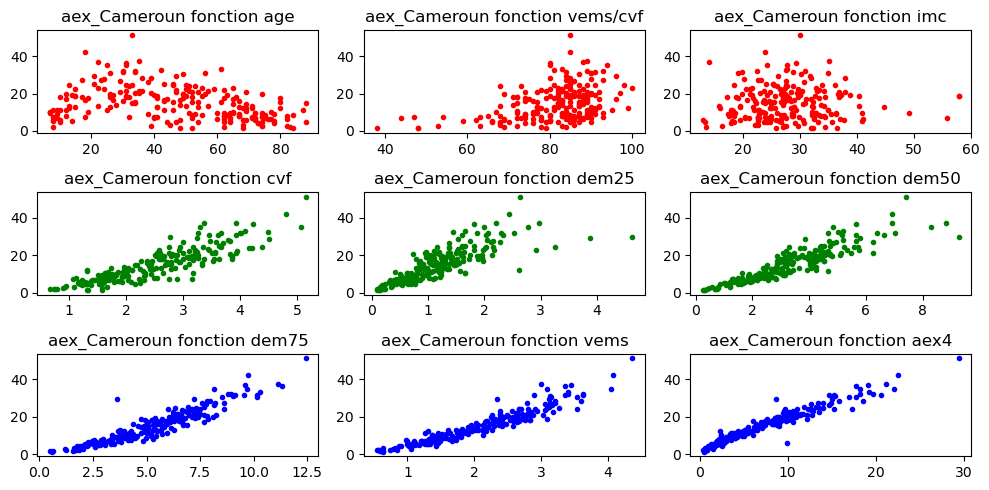

In [87]:
fig, axs = plt.subplots(3, 3, figsize=(10, 5))
#plt.figure(figsize=(15,10))
#fig, axs = plt.subplots(3, 3)

axs[0, 0].plot(df['age'], df['aex_cameroun'], "r.")
axs[0, 0].set_title("aex_Cameroun fonction age")
axs[0, 1].plot(df['vems/cvf'], df['aex_cameroun'], "r.")
axs[0, 1].set_title("aex_Cameroun fonction vems/cvf")
axs[0, 2].plot(df['imc'], df['aex_cameroun'], "r.")
axs[0, 2].set_title("aex_Cameroun fonction imc")
axs[1, 0].plot(df['cvf'], df['aex_cameroun'], "g.")
axs[1, 0].set_title("aex_Cameroun fonction cvf")
axs[1, 1].plot(df['dem25'], df['aex_cameroun'], "g.")
axs[1, 1].set_title("aex_Cameroun fonction dem25")
axs[1, 2].plot(df['dem50'], df['aex_cameroun'], "g.")
axs[1, 2].set_title("aex_Cameroun fonction dem50")
axs[2, 0].plot(df['dem75'], df['aex_cameroun'], "b.")
axs[2, 0].set_title("aex_Cameroun fonction dem75")
axs[2, 1].plot(df['vems'], df['aex_cameroun'], "b.")
axs[2, 1].set_title("aex_Cameroun fonction vems")
axs[2, 2].plot(df['aex4'], df['aex_cameroun'], "b.")
axs[2, 2].set_title("aex_Cameroun fonction aex4")

# espacer les différents graphiques
fig.tight_layout()

plt.show()

> ****

> **<h3><font color="#0000FF">III -  ANALYSE PREDICTIVE</font></h3>**

> Importation des bibliothèques

In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn import preprocessing

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector

from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import VotingRegressor
from sklearn.metrics import make_scorer
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from RegscorePy import *
from sklearn.model_selection import learning_curve

In [89]:
data = df.copy()

In [90]:
data.columns

Index(['sexe', 'age', 'imc', 'vems', 'cvf', 'vems/cvf', 'dem25', 'dem50',
       'dem75', 'aex4', 'aex_cameroun'],
      dtype='object')

> 1 - Sélection de la base des données de prédiction

In [91]:
df = df.drop(columns = ['sexe', 'age', 'imc', 'aex4'])

In [92]:
df.head(2)

,vems,cvf,vems/cvf,dem25,dem50,dem75,aex_cameroun
0,2.19,2.57,85.0,1.30,4.36,6.61,17.86
1,1.01,1.28,79.0,0.52,1.58,2.08,4.78


> 2 - selection des prédicteurs et de la variable réponse

In [93]:
y = df['aex_cameroun']
X = df.drop(columns =['aex_cameroun'])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

> 3 - Normalisationdes données pour les utiliser dans certains modèles

In [94]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [95]:
# définition du pipeline et de algorithmes de prédiction
preprocessor= ColumnTransformer(transformers=[('scaler',  RobustScaler(), make_column_selector(dtype_include=np.number))])


# Forêt aléatoire
RF = Pipeline(steps=[('preprocessor', preprocessor ),
                   ('RF', RandomForestRegressor(random_state=0)) ])

# Gradient boosting 
GB = Pipeline(steps=[('preprocessor', preprocessor ),
                   ('GB', GradientBoostingRegressor(random_state=0)) ])

# Plus proches voisins 
KNN = Pipeline(steps=[('preprocessor', preprocessor ),
                   ('KNN', KNeighborsRegressor()) ])

# Machine à vecteur de support
MVS = Pipeline(steps=[('preprocessor', preprocessor ),
                   ('MVS', svm.SVR())])

# Reseau de neurones
MLP = Pipeline(steps=[('preprocessor', preprocessor ),
                   ('MLP', MLPRegressor(random_state=0))])

> 4 - Recherche des hypers parametres optimaux

In [96]:
# Définir la plage des hyperparamètres pour le modèle Forêt aleatoire
distributions = dict(max_depth=np.arange(1,10),
                     n_estimators=np.arange(60,600))
clf_RF = RandomizedSearchCV(RF.steps[1][1], distributions, random_state=1, scoring = 'neg_root_mean_squared_error')
search_RF = clf_RF.fit(X_train, y_train)



# Gradient boosting
distributions = dict(max_depth=np.arange(1,10),
                     n_estimators=np.arange(60,600))
clf_GB = RandomizedSearchCV(GB.steps[1][1], distributions, random_state=1)
search_GB = clf_GB.fit(X_train, y_train)



# Définir la plage des hyperparamètres pour le modèle KNN
distributions = dict(n_neighbors=np.arange(1,100))
# Configurer la recherche aléatoire
Rand_CV = RandomizedSearchCV(KNN.steps[1][1], distributions, random_state=1,  scoring = "neg_root_mean_squared_error")
search_KNN =  Rand_CV.fit(X_train_scaled, y_train)



# Définir la plage des hyperparamètres pour le model MVS
params = {'C':[0.01,0.05,0.1,0.5,1,2,5],'epsilon':[0.1,0.2,0.5,1]}
# Configurer la recherche aléatoire
Rand_CV = RandomizedSearchCV(MVS.steps[1][1],param_distributions=params,cv=5,scoring='neg_root_mean_squared_error',verbose=1,return_train_score=True)
search_MVS = Rand_CV.fit(X_train,y_train)



# Définir la plage des hyperparamètres pour le model MPL
distributions = dict(hidden_layer_sizes=np.arange(1,1000))
# Configurer la recherche aléatoire
clf_MPL = RandomizedSearchCV(MLP.steps[1][1], distributions, random_state=1, scoring = 'neg_root_mean_squared_error')
search_MPL =  clf_MPL.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [97]:
print('meilleur hypers parametres RF', search_RF.best_params_, sep = '---')
print('meilleur hypers parametres GB', search_GB.best_params_, sep = '---')
print('meilleur hypers parametres KNN', search_KNN.best_params_, sep = '---')
print('meilleur hypers parametres MVS' , search_MVS.best_estimator_, sep = '---')
print('meilleur hypers parametres MPL', search_MPL.best_params_, sep = '---')

meilleur hypers parametres RF---{'n_estimators': 505, 'max_depth': 8}
meilleur hypers parametres GB---{'n_estimators': 425, 'max_depth': 2}
meilleur hypers parametres KNN---{'n_neighbors': 18}
meilleur hypers parametres MVS---SVR(C=5, epsilon=1)
meilleur hypers parametres MPL---{'hidden_layer_sizes': 929}


> 5 - Définition de tous les modèles avec leurs hyperparamètres respectifs

In [98]:
# Forêt aléatoire
RF = Pipeline(steps=[('preprocessor', preprocessor ),
                   ('RF', RandomForestRegressor(n_estimators = 505, max_depth = 8, random_state=12)) ])

# Gradient boosting 
GB = Pipeline(steps=[('preprocessor', preprocessor ),
                   ('GB', GradientBoostingRegressor(n_estimators = 425, max_depth = 2, random_state=12)) ])

# K Plus proches voisins 
KNN = Pipeline(steps=[('preprocessor', preprocessor ),
                   ('KNN', KNeighborsRegressor(n_neighbors = 18)) ])

# Machine à vecteur de support
MVS = Pipeline(steps=[('preprocessor', preprocessor ),
                   ('MVS', svm.SVR(C = 5, epsilon = 1))])

# Reseau de neurones
MLP = Pipeline(steps=[('preprocessor', preprocessor ),
                   ('MLP', MLPRegressor(hidden_layer_sizes = 929, random_state=12))])

> 6 - Boucle d'évaluation de tous les modèles

In [99]:
models = [('Forêt aléatoire', RF),
          ('Gradient Boosting', GB),
          ('K Plus proches voisins', KNN),
          ('Machine à vecteur de support', MVS),
          ('Reseau de neurones', MLP)]



for model in models: #for loop through the three models
    reg = model[1]  #initialize the model object
    reg.fit(X_train,y_train)  #fitting the training data
    y_pred = reg.predict(X_test)  #predict target
    print(model[0])
    print('R2: ',r2_score(y_test, y_pred))  #check r2 score
    print('MSE: ',mean_squared_error(y_test, y_pred))
    print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_pred)))  #check root mean squared error
    print('AIC: ',aic.aic(y_test, y_pred, 2))
    print('-'*30)

Forêt aléatoire
R2:  0.9803688780659372
MSE:  1.0876176337302843
RMSE:  1.0428890802622703
AIC:  7.695544471443053
------------------------------
Gradient Boosting
R2:  0.991326969454848
MSE:  0.48050951904185984
RMSE:  0.6931879391924385
AIC:  -28.247962562946157
------------------------------
K Plus proches voisins
R2:  0.9819045636507929
MSE:  1.002536468855219
RMSE:  1.0012674312366396
AIC:  4.111463327684277
------------------------------
Machine à vecteur de support
R2:  0.980083665515762
MSE:  1.103419185978473
RMSE:  1.0504376164144509
AIC:  8.330203229384622
------------------------------
Reseau de neurones
R2:  0.9587510655276732
MSE:  2.2853033390233137
RMSE:  1.5117219780843678
AIC:  40.36594578509887
------------------------------


#### le gradient boosting à la valeur de l'AIC la plus basse; on va utiliser cette algorithme pour la prédiction

> 7 - Courbes d'apprentissage pour les différents modèles

In [ ]:
fig = plt.figure(figsize=(10,6))
plt.subplot(3,2,1)
N, train_score, val_score = learning_curve(RF, X_train, y_train, 
                                           train_sizes = np.linspace(0.01, 1.0, 25), cv = 5)
print(N)
plt.plot(N,train_score.mean(axis=1), label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('Foêt aléatoire', color = 'b', fontsize = 13)
plt.legend(fontsize = 11)


#plt.figure(figsize=(10,6))
plt.subplot(3,2,2)
N, train_score, val_score = learning_curve(GB, X_train, y_train, 
                                           train_sizes = np.linspace(0.01, 1.0, 25), cv = 5)
print(N)
plt.plot(N,train_score.mean(axis=1), label='train', color = '#574460')
plt.plot(N,val_score.mean(axis=1), label='validation', color = '#009999')
plt.xlabel('Boost du gradient', color = 'g', fontsize = 13)
plt.legend(fontsize = 11)


#plt.figure(figsize=(10,6))
plt.subplot(3,2,3)
N, train_score, val_score = learning_curve(KNN, X_train, y_train, 
                                           train_sizes = np.linspace(0.01, 1.0, 25), cv = 5)
print(N)
plt.plot(N,train_score.mean(axis=1), label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('K plus proches voisins', color = 'b', fontsize = 13)
plt.legend(fontsize = 11)


#plt.figure(figsize=(10,6))
plt.subplot(3,2,4)
N, train_score, val_score = learning_curve(MVS, X_train, y_train, 

                                           train_sizes = np.linspace(0.01, 1.0, 25), cv = 5)
print(N)
plt.plot(N,train_score.mean(axis=1), label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('Machine à vecteur de support', fontsize = 13)
plt.legend(fontsize = 11)


#plt.figure(figsize=(10,6))
plt.subplot(3,2,5)
N, train_score, val_score = learning_curve(MLP, X_train, y_train, 

                                           train_sizes = np.linspace(0.01, 1.0, 25), cv = 5)
print(N)
plt.plot(N,train_score.mean(axis=1), label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('Réseau de neurones', color = 'b', fontsize = 13)
plt.legend(fontsize = 11)
fig.tight_layout()

[  1   7  12  18  24  30  36  41  47  53  59  64  70  76  82  88  93  99
 105 111 116 122 128 134 140]
[  1   7  12  18  24  30  36  41  47  53  59  64  70  76  82  88  93  99
 105 111 116 122 128 134 140]
[  1   7  12  18  24  30  36  41  47  53  59  64  70  76  82  88  93  99
 105 111 116 122 128 134 140]
[  1   7  12  18  24  30  36  41  47  53  59  64  70  76  82  88  93  99
 105 111 116 122 128 134 140]


> Fonction de prédiction

In [51]:
# Pour les raisons de calcul: on renomme le rapport vms/cvf en vems_cvf 
df.columns = df.columns.str.replace('vems/cvf', 'vems_cvf')
y = df['aex_cameroun']
X = df.drop(columns =['aex_cameroun'])
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

In [52]:
df.head()

,vems,cvf,vems_cvf,dem25,dem50,dem75,aex_cameroun
0,2.19,2.57,85.0,1.30,4.36,6.61,17.86
1,1.01,1.28,79.0,0.52,1.58,2.08,4.78
2,2.31,2.61,89.0,1.52,4.30,6.15,17.95
3,3.00,3.37,89.0,2.20,8.84,11.12,37.39
4,3.08,3.86,80.0,1.43,3.14,4.75,18.94


In [53]:
## Fonction de calcul
def prediction_aex_cameroun (vems, cvf, vems_cvf, dem25, dem50, dem75):
    # Prediction espérance = médiane
    predicteur = Pipeline(steps=[('preprocessor', preprocessor ),
                   ('GB', GradientBoostingRegressor(n_estimators = 425, max_depth = 2, random_state=12)) ])
    predicteur.fit(X_train, y_train)
    var = {'vems':[vems],
           'cvf':[cvf],
           'vems_cvf':[vems_cvf],
           'dem25':[dem25],
           'dem50':[dem50],
           'dem75':[dem75] 
          }
    X1 = pd.DataFrame (var)
    pred_aex_cameroun = predicteur.predict(X1)
    table = pd.DataFrame([pred_aex_cameroun[0]]).T
    table.columns = ["aex_cameroun"]
    return table

##### Vérification: prédiction de aex_cameroun pour la ligne 74 de notre table

In [61]:
pred = prediction_aex_cameroun (vems = 3.06, cvf = 3.57, vems_cvf = 86.0, dem25 = 2.12, dem50 = 4.95, dem75 = 7.79).T
pred.columns = ["values"]
prediction = pred.T
print('Valeur prédicte de aex_cameroun')
prediction

Valeur prédicte de aex_cameroun


,aex_cameroun
values,27.570627


In [62]:
print('Valeur réel de aex_cameroun')
df.loc[df.index[5], 'aex_cameroun']

Valeur réel de aex_cameroun


26.87

> Rassembler plusieurs prédicteurs pour choisir le plus performent lors de la prédiction

In [63]:
reg1 = RF
reg2 = GB
reg3 = MVS
reg4 = MLP
ereg = VotingRegressor(estimators=[('rf', reg1), ('gb', reg2), ('mvs', reg3), ('mlp', reg4)])
ereg = ereg.fit(X_train, y_train)

In [64]:
ereg

VotingRegressor(estimators=[('rf',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('scaler',
                                                                               RobustScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x0000021598B130D0>)])),
                                             ('RF',
                                              RandomForestRegressor(max_depth=8,
                                                                    n_estimators=505,
                                                                    random_state=12))])),
                            ('gb',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(tran...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x0000021598B130D0>)])),
                                             ('MVS', SVR(C=5, epsilon=0.2))])),
                            ('mlp',
                             Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('scaler',
                                                                               RobustScaler(),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x0000021598B130D0>)])),
                                             ('MLP',
                                              MLPRegressor(hidden_layer_sizes=929,
                                                           random_state=12))]))])

In [65]:
## Fonction de calcul
def stacking_prediction_aex_cameroun (vems, cvf, vems_cvf, dem25, dem50, dem75):
    # Prediction espérance = médiane
    predicteur = ereg
    predicteur.fit(X_train, y_train)
    var = {'vems':[vems],
           'cvf':[cvf],
           'vems_cvf':[vems_cvf],
           'dem25':[dem25],
           'dem50':[dem50],
           'dem75':[dem75] 
          }
    X1 = pd.DataFrame (var)
    pred_aex_cameroun = predicteur.predict(X1)
    table = pd.DataFrame([pred_aex_cameroun[0]]).T
    table.columns = ["aex_cameroun"]
    return table

> Prédiction avec l'ensemble des prédicteurs 

In [66]:
stack_pred = stacking_prediction_aex_cameroun (vems = 3.06, cvf = 3.57, vems_cvf = 86.0, dem25 = 2.12, dem50 = 4.95, dem75 = 7.79).T
stack_pred.columns = ["values"]
print('Valeur prédicte de aex_cameroun')
prediction = stack_pred.T
prediction

Valeur prédicte de aex_cameroun


,aex_cameroun
values,27.062891


#### La prédiction est meilleur lorsqu'on regroupe plusieurs algorithmes 